In [6]:
#!pip install tensorflow==2.11.1
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
import psutil

import h5py
import gc
import qkeras
import tensorflow_model_optimization

2024-07-02 10:16:33.608492: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 10:16:33.671673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-02 10:16:33.673272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 10:16:35.701036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
2.13.1


In [2]:
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

In [5]:
def load_combine_shuffle_data_optimized_hdf5():
    with h5py.File('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/fl32_data_v3.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for data_type in ['sig', 'bkg']:
            # Construct dataset names
            input_dataset_name = f'{data_type}_input'
            target_dataset_name = f'{data_type}_target'

            # Check if the dataset exists and load data sequentially
            if input_dataset_name in h5f and target_dataset_name in h5f:
                input_data = h5f[input_dataset_name][:].astype(np.float32)
                target_data = h5f[target_dataset_name][:].astype(np.float32)

                if combined_input is None:
                    combined_input = input_data
                    combined_target = target_data
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

                else:
                    print_memory_usage()
                    combined_input = np.vstack((combined_input, input_data))
                    combined_target = np.vstack((combined_target, target_data))
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

            else:
                print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

# Example usage
X, y = load_combine_shuffle_data_optimized_hdf5()

Total memory: 376.23 GB
Available memory: 262.03 GB
Used memory: 103.40 GB
Memory usage percentage: 30.4%


In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def display(x_dataset, y_dataset, i):
    # Extract the i-th data point from both datasets
    x_data_point = x_dataset[i]
    y_data_point = y_dataset[i]

    # Check if the index is valid
    if x_data_point.shape != (20, 13, 21):
        raise ValueError("Invalid shape for the x data point")

    # Extracting the transverse momentum (pt) from the y dataset
    pt = y_data_point[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(8, 6))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(x_data_point[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(x_data_point.shape[1]))
    ax_main.set_xticks(np.arange(x_data_point.shape[2]))
    ax_main.set_xlim(0, x_data_point.shape[2]-1)
    ax_main.set_ylim(0, x_data_point.shape[1]-1)
    ax_main.grid(True, color='gray', alpha=0.7)

    # Function to update the animation
    def update(t):
        # Update main plot
        data = x_data_point[t, :, :]
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(x_data_point[:, :, :].sum(axis=2)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(x_data_point[:, :, :].sum(axis=1)) * 1.1, np.max(x_data_point[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")


        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f}")

    ani = FuncAnimation(fig, update, frames=8, repeat=True)
    plt.close()

    return HTML(ani.to_jshtml())

In [7]:
n = X.shape[0]
X = X.reshape(n,20,13,21)
display(X, y, 19)

In [ ]:
def display_diff(x_dataset, y_dataset, i):
    # Extract the i-th data point from both datasets
    x_data_point = x_dataset[i]
    y_data_point = y_dataset[i]

    # Check if the index is valid
    if x_data_point.shape != (20, 13, 21):
        raise ValueError("Invalid shape for the x data point")

    # Extracting the transverse momentum (pt) from the y dataset
    pt = y_data_point[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(8, 6))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(x_data_point[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(x_data_point.shape[1]))
    ax_main.set_xticks(np.arange(x_data_point.shape[2]))
    ax_main.set_xlim(0, x_data_point.shape[2]-1)
    ax_main.set_ylim(0, x_data_point.shape[1]-1)
    ax_main.grid(True, color='gray', alpha=0.7)

    # Function to update the animation
    def update(t):
        # Calculate the difference between current and previous timestep
        if t == 0:
            data = x_data_point[t, :, :]
        else:
            data = x_data_point[t, :, :] - x_data_point[t-1, :, :]
        
        # Update main plot
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(data.sum(axis=1)) * 1.1, np.max(data.sum(axis=1)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(data.sum(axis=0)) * 1.1, np.max(data.sum(axis=0)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")

        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f}")

    ani = FuncAnimation(fig, update, frames=20, repeat=True)
    plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
display_diff(X, y, 1299)

In [ ]:
def check_zero_differences_all(x_dataset, start):
    # Get the number of data points in the dataset
    num_data_points = x_dataset.shape[0]
    all_zero_diff = True
    # Iterate over all data points
    for i in range(num_data_points):
        # Extract the i-th data point from the dataset
        x_data_point = x_dataset[i]

        # Check if the index is valid
        if x_data_point.shape != (20, 13, 21):
            raise ValueError(f"Invalid shape for data point {i}")

        print(f"Checking data point {i}:")

        # Flag to track if all differences are zero
        
        # Iterate over time steps starting from the 9th time frame
        for t in range(start, 20):
            # Calculate the difference between current and previous timestep
            diff = x_data_point[t, :, :] - x_data_point[t-1, :, :]

            # Check if all differences are zero
            if not np.allclose(diff, 0):
                all_zero_diff = False
                print(f"  Timestep {t+1}: Non-zero differences exist.")
                break

    if all_zero_diff:
        print(f"  All differences are zero for timesteps {start} to 20.")

    print()  # Print an empty line for separation
check_zero_differences_all(X, 13)

In [8]:
X = X.reshape(-1, 20*13*21)
n = X.shape[0]
X = X.reshape(n,20,13,21)
X= X[:, :8, :, :]
print_memory_usage()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
gc.collect()
print_memory_usage()
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
del X_temp
del y_temp
gc.collect()
print_memory_usage()

Total memory: 376.23 GB
Available memory: 262.82 GB
Used memory: 102.62 GB
Memory usage percentage: 30.1%
Total memory: 376.23 GB
Available memory: 269.52 GB
Used memory: 95.91 GB
Memory usage percentage: 28.4%
Total memory: 376.23 GB
Available memory: 269.52 GB
Used memory: 95.92 GB
Memory usage percentage: 28.4%


In [9]:
def to_sum(X, y):
    if X.shape[1:] == (8, 13, 21) and y.shape[1:] == (13, ):
        #y_expanded = np.repeat(y[:,7], 8, axis=0).reshape(-1, 8, 1)
        X_sum = np.sum(X, axis=3)
        X_sum.reshape(X_sum.shape[0],8,13,1)
        n = y.shape[0]
        # one_hot = np.zeros((n, 3))
        one_hot = np.zeros((n, 1))

        # Class 1: np.abs(y[:, 8]) > 2
        one_hot[np.abs(y[:, 8]) >= 2, 0] = 1
        # one_hot[np.abs(y[:, 8]) < 2, 1] = 1

        # # Class 2: np.abs(y[:, 8]) <= 2 and y[:, 13] == 1
        # one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] > 0), 1] = 1

        # # Class 3: np.abs(y[:, 8]) <= 2 and y[:, 13] == -1
        # one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] < 0), 2] = 1
        return X_sum, one_hot, y[:,7].reshape(-1, 1)
    else:
        raise ValueError("Wrong array shape!")

X_sum_train, y_sum_train, y0_train = to_sum(X_train, y_train)
X_sum_val, y_sum_val, y0_val = to_sum(X_val, y_val)
X_sum_test, y_sum_test, y0_test = to_sum(X_test, y_test)
del X_train
del y_train
del X_val
del y_val
del X_test
del y_test
gc.collect()
print_memory_usage()

Total memory: 376.23 GB
Available memory: 273.75 GB
Used memory: 91.68 GB
Memory usage percentage: 27.2%


In [10]:
print(X_sum_test.shape)
print(y_sum_test.shape)
print(y0_test.shape)

(54843, 8, 13)
(54843, 1)
(54843, 1)


In [11]:
from sklearn.preprocessing import StandardScaler
X_sum_train = X_sum_train.reshape(-1,104)
X_sum_val = X_sum_val.reshape(-1,104)
X_sum_test = X_sum_test.reshape(-1,104)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_sum_train)
X_val_norm = scaler.transform(X_sum_val)
X_test_norm = scaler.transform(X_sum_test)
scaler_y0 = StandardScaler()
y0_train = scaler_y0.fit_transform(y0_train)
y0_val = scaler_y0.transform(y0_val)
y0_test = scaler_y0.transform(y0_test)

In [12]:
X_train_norm = X_train_norm.reshape(-1, 8, 13)
X_val_norm = X_val_norm.reshape(-1, 8, 13)
X_test_norm = X_test_norm.reshape(-1, 8, 13)

In [13]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

qmodel_pruned = load_model('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/CNN_maybebest_quantized_pruned.h5', custom_objects=co)

In [14]:
X_sum_test_flattened = X_test_norm.reshape(54843, -1)

# Concatenate X_sum_test_flattened with y0_test along axis 1 to get a (54843, 105) shape
input_features = np.hstack((X_sum_test_flattened, y0_test))

# Write to file
with open('tb_input_features_small.dat', 'w') as file:
    for row in input_features:
        line = ' '.join(map(str, row))  # Convert each number to string and join with space
        file.write(line + '\n')

In [15]:
with open('./tb_output_predictions_small.dat', 'w') as file:
    for score in y_sum_test:
        file.write(str(score[0]) + '\n')  # Convert number to string

In [13]:
NUM_TIME_SLICES = 8
CONV_LAYER_DEPTHS = [4, 7]
CONV_LAYER_KERNELS = [(3, 3), (3, 3)]
CONV_LAYER_STRIDES = [(1, 1), (1, 1)]
FLATTENED_LAYERS = [7]
MAX_POOLING_SIZE = (2,2)
INTEGER_BITS = 2
WEIGHTS_BITS = 10
BIAS_BITS = 10
ACTIVATION_BITS = 15


from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
def qCNNmodel():
    y_profile_input = Input(shape=(NUM_TIME_SLICES, 13, 1), name='y_profile_input')  # Adjust the shape based on your input
    layer = y_profile_input

    # Convolutional layers
    for i in range(len(CONV_LAYER_DEPTHS)):
        layer = QConv2D(
        CONV_LAYER_DEPTHS[i],
        kernel_size=CONV_LAYER_KERNELS[i],
        strides=CONV_LAYER_STRIDES[i],
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        padding='same',
        use_bias=True,
        name=f'conv{i+1}'
        )(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
        layer = MaxPooling2D(pool_size=MAX_POOLING_SIZE, name=f'maxpool{i+1}')(layer)

    # Flatten the output to feed into a dense layer
    layer = Flatten(name='flattened')(layer)

    # Flatten and concatenate with y0 input
    y0_input = Input(shape=(1,), name='y0_input')
    layer = Concatenate(name='concat')([layer, y0_input])

    # Post-flattening dense layers
    for i in range(len(FLATTENED_LAYERS)):
        layer = QDense(FLATTENED_LAYERS[i], kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'dense{i+1}')(layer)
        layer = QActivation(quantized_relu(10), name=f'relu{len(CONV_LAYER_DEPTHS)+i+1}')(layer)

    # Output layer (adjust based on your classification problem)
    # output = Dense(3, activation='softmax', name='output_softmax')(dropout)  # Change number of neurons based on the number of classes
    layer = QDense(1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
                   bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name='output_dense')(layer)
    output = Activation("sigmoid", name='output_sigmoid')(layer)

    model = Model(inputs=[y_profile_input, y0_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # loss='categorical_crossentropy'

    return model
# Example usage
model = qCNNmodel()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 y_profile_input (InputLaye  [(None, 8, 13, 1)]           0         []                            
 r)                                                                                               
                                                                                                  
 conv1 (QConv2D)             (None, 8, 13, 4)             40        ['y_profile_input[0][0]']     
                                                                                                  
 relu1 (QActivation)         (None, 8, 13, 4)             0         ['conv1[0][0]']               
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 4, 6, 4)              0         ['relu1[0][0]']         

In [17]:
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=20,
                                   restore_best_weights=True)

In [18]:
epochs = 100  # Number of epochs to train
batch_size = 1024  # Number of samples per gradient update

# Train the model
history = model.fit(
    [X_train_norm, y0_train], y_sum_train,  # Training data and labels
    validation_data=([X_val_norm, y0_val], y_sum_val),  # Validation data
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[earlyStop_callback]
)

Epoch 1/100
429/429 [==============================] - 9s 17ms/step - loss: 0.6939 - accuracy: 0.5030 - val_loss: 0.6930 - val_accuracy: 0.5067
Epoch 2/100
429/429 [==============================] - 7s 16ms/step - loss: 0.6930 - accuracy: 0.5074 - val_loss: 0.6928 - val_accuracy: 0.5117
Epoch 3/100
429/429 [==============================] - 7s 16ms/step - loss: 0.6928 - accuracy: 0.5083 - val_loss: 0.6926 - val_accuracy: 0.5118
Epoch 4/100
429/429 [==============================] - 7s 15ms/step - loss: 0.6926 - accuracy: 0.5124 - val_loss: 0.6923 - val_accuracy: 0.5176
Epoch 5/100
429/429 [==============================] - 7s 15ms/step - loss: 0.6922 - accuracy: 0.5165 - val_loss: 0.6920 - val_accuracy: 0.5199
Epoch 6/100
429/429 [==============================] - 7s 15ms/step - loss: 0.6918 - accuracy: 0.5190 - val_loss: 0.6915 - val_accuracy: 0.5189
Epoch 7/100
429/429 [==============================] - 7s 15ms/step - loss: 0.6911 - accuracy: 0.5225 - val_loss: 0.6905 - val_accuracy:

In [19]:
model.save('./CNN_new_Small_quantized.h5')

/sdf/home/a/alexyue/miniconda3/envs/SmartPixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(model)

conv1                f=4 quantized_bits(10,2,0,alpha=1.0) quantized_bits(10,2,0,alpha=1.0) 
q_activation         quantized_relu(10,0)
conv2                f=7 quantized_bits(10,2,0,alpha=1.0) quantized_bits(10,2,0,alpha=1.0) 
q_activation_1       quantized_relu(10,0)
dense1               u=7 quantized_bits(10,2,0,alpha=1.0) quantized_bits(10,2,0,alpha=1.0) 
q_activation_2       quantized_relu(10,0)
dense2               u=1 quantized_bits(10,2,0,alpha=1.0) quantized_bits(10,2,0,alpha=1.0) 



In [21]:
# import tensorflow
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(X_sum_train.shape[0] * 0.9) // 1024  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))

# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params1 = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.25,
            begin_step=NSTEPS * 2,
            end_step=NSTEPS * 7,
            frequency=NSTEPS
        )
    }

    pruning_params2 = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.25,
            begin_step=NSTEPS * 2,
            end_step=NSTEPS * 7,
            frequency=NSTEPS
        )
    }

    # if isinstance(layer, QConv2DBatchnorm):
    #     print(f"find layer {layer.name} prunable")
    #     return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)

    if isinstance(layer, QDense):
        if layer.name != 'output_softmax' and layer.name != 'dense2':
            print(f"find layer {layer.name} prunable")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params1)
        elif layer.name != 'output_softmax' and layer.name != 'dense1':
            print(f"find layer {layer.name} prunable")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params2)
        else:
            print(f"find layer {layer.name} not prunable")
            return layer

    else:
        print(f"find layer {layer.name} not prunable")
        return layer
qmodel_pruned = 0
qmodel_pruned = keras.models.clone_model(model, clone_function=pruneFunction)
qmodel_pruned.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Number of training steps per epoch is 385
find layer conv1 not prunable
find layer q_activation not prunable
find layer maxpool1 not prunable
find layer conv2 not prunable
find layer q_activation_1 not prunable
find layer maxpool2 not prunable
find layer flattened not prunable
find layer concat not prunable
find layer dense1 prunable
find layer q_activation_2 not prunable
find layer dense2 prunable
find layer output_sigmoid not prunable


In [26]:
epochs = 25  # Number of epochs to train
batch_size = 1024  # Number of samples per gradient update

# Train the model
history = qmodel_pruned.fit(
    [X_train_norm, y0_train], y_sum_train,  # Training data and labels
    validation_data=([X_val_norm, y0_val], y_sum_val),  # Validation data
    epochs=epochs,
    batch_size=batch_size,
    callbacks = [pruning_callbacks.UpdatePruningStep()]
)

Epoch 1/25
429/429 [==============================] - 9s 16ms/step - loss: 0.6396 - accuracy: 0.6306 - val_loss: 0.6441 - val_accuracy: 0.6294
Epoch 2/25
429/429 [==============================] - 7s 16ms/step - loss: 0.6397 - accuracy: 0.6298 - val_loss: 0.6428 - val_accuracy: 0.6275
Epoch 3/25
429/429 [==============================] - 8s 19ms/step - loss: 0.6392 - accuracy: 0.6310 - val_loss: 0.6405 - val_accuracy: 0.6293
Epoch 4/25
429/429 [==============================] - 8s 19ms/step - loss: 0.6387 - accuracy: 0.6319 - val_loss: 0.6404 - val_accuracy: 0.6299
Epoch 5/25
429/429 [==============================] - 8s 20ms/step - loss: 0.6392 - accuracy: 0.6303 - val_loss: 0.6429 - val_accuracy: 0.6272
Epoch 6/25
429/429 [==============================] - 9s 20ms/step - loss: 0.6393 - accuracy: 0.6307 - val_loss: 0.6414 - val_accuracy: 0.6281
Epoch 7/25
429/429 [==============================] - 8s 20ms/step - loss: 0.6389 - accuracy: 0.6307 - val_loss: 0.6404 - val_accuracy: 0.6297

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

1714/1714 [==============================] - 5s 3ms/step


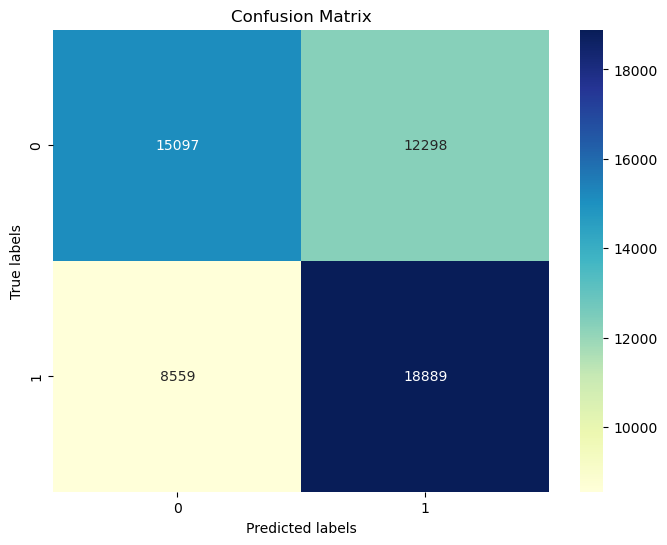

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions_prob = qmodel_pruned.predict([X_test_norm, y0_test])
predictions_labels = (predictions_prob >= 0.5).astype(int).flatten()
y_test_labels = y_sum_test

cm = confusion_matrix(y_test_labels, predictions_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#print(predictions_prob[0:30])
print(y_sum_test[0:30])

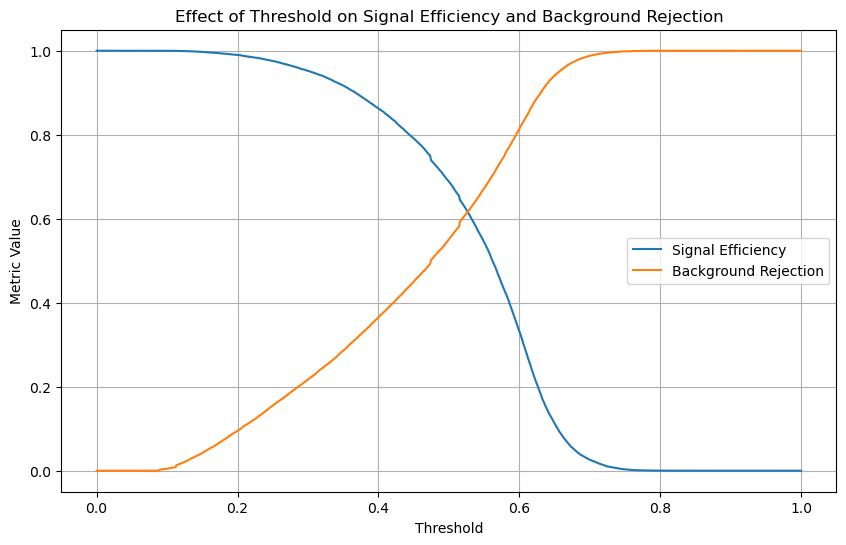

In [24]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.0, 1.0, 1000)
signal_efficiencies = []
background_rejections = []

for threshold in thresholds:
    # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
    predicted_class = (predictions_prob > threshold).astype(int)
    # Compute confusion matrix
    cm = confusion_matrix(y_sum_test[:, 0], predicted_class)

    # Calculate signal efficiency and background rejection
    signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
    background_rejection = cm[0, 0] / np.sum(cm[0, :])

    # Store metrics
    signal_efficiencies.append(signal_efficiency)
    background_rejections.append(background_rejection)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency')
plt.plot(thresholds, background_rejections, label='Background Rejection')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Effect of Threshold on Signal Efficiency and Background Rejection')
plt.legend()
plt.grid(True)
plt.show()

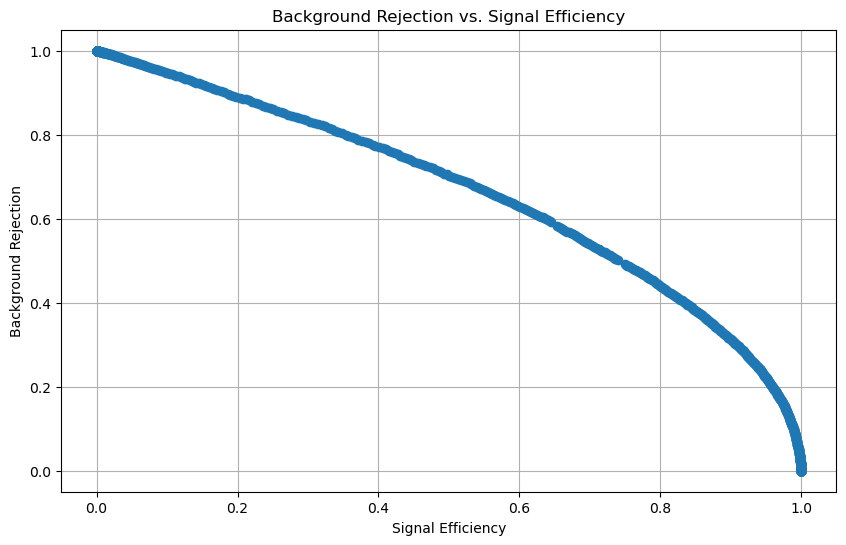

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(signal_efficiencies, background_rejections, marker='o')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Background Rejection vs. Signal Efficiency')
plt.grid(True)
plt.show()

In [28]:
def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)

    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)

    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)

    return closest_index


index_848 = find_closest(signal_efficiencies, 0.848)
index_933 = find_closest(signal_efficiencies, 0.933)
index_976 = find_closest(signal_efficiencies, 0.976)
index_995 = find_closest(signal_efficiencies, 0.995)
index_997 = find_closest(signal_efficiencies, 0.997)
print(f"Signal Efficiency:{signal_efficiencies[index_848]*100:.1f}%",f"Background Rejections:{background_rejections[index_848]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_933]*100:.1f}%",f"Background Rejections:{background_rejections[index_933]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_976]*100:.1f}%",f"Background Rejections:{background_rejections[index_976]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_995]*100:.1f}%",f"Background Rejections:{background_rejections[index_995]*100:.1f}%")
print(f"Signal Efficiency:{signal_efficiencies[index_997]*100:.1f}%",f"Background Rejections:{background_rejections[index_997]*100:.1f}%")

Signal Efficiency:84.8% Background Rejections:38.4%
Signal Efficiency:93.3% Background Rejections:25.7%
Signal Efficiency:97.6% Background Rejections:15.4%
Signal Efficiency:99.5% Background Rejections:5.9%
Signal Efficiency:99.7% Background Rejections:4.3%


In [ ]:
print(np.sum(y_sum_train[:,0]))
print(y_sum_train.shape)

In [31]:
qmodel_pruned.save('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/CNN_noBN_small_quantized_pruned.h5')

/fs/ddn/sdf/group/atlas/d/hjia625/CONDA/envs/Smart_Pixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
import hls4ml
import os
os.environ['XILINX_HLS'] = '/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2023.1/Vitis_HLS/2023.1'
os.environ['XILINX_VIVADO'] = '/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2023.1/Vivado/2023.1'
os.environ['XILINX_VITIS'] = '/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2023.1/Vitis/2023.1'
os.environ['XILINX_AP_INCLUDE'] = '/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/HLS_arbitrary_Precision_Types/include'
os.environ['PATH'] = os.environ['XILINX_HLS'] + '/bin:' + os.environ['PATH']
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']
os.environ['PATH'] = os.environ['XILINX_AP_INCLUDE'] + '/bin:' + os.environ['PATH']

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/fs/ddn/sdf/group/atlas/d/hjia625/CONDA/envs/Smart_Pixel/lib/python3.8/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [23]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
strip_model = strip_pruning(qmodel_pruned)
hls_config = hls4ml.utils.config_from_keras_model(strip_model , granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<10,2,AP_RND_ZERO,AP_SAT>'
hls_config['Model']['ReuseFactor'] = 1

for Layer in hls_config['LayerName'].keys():
    print(Layer)
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
    hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<10,2,AP_RND_ZERO,AP_SAT>'

# If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_sigmoid']['Strategy'] = 'Stable'
hls_config['LayerName']['output_sigmoid']['Precision'] = 'ap_fixed<32,8,AP_RND_ZERO,AP_SAT>'

cfg = hls4ml.converters.create_config(backend='Vitis')

cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'cnn_debug/'
cfg['XilinxPart'] = 'xcku040-ffva1156-2-e'

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()
#hls_model.profile()
hls_model.build()

Interpreting Model
Topology:
Layer name: y_profile_input, layer type: InputLayer, input shapes: [[None, 8, 13, 1]], output shape: [None, 8, 13, 1]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 8, 13, 1]], output shape: [None, 8, 13, 8]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 8, 13, 8]], output shape: [None, 8, 13, 8]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 8, 13, 8]], output shape: [None, 4, 6, 8]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 4, 6, 8]], output shape: [None, 4, 6, 13]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 4, 6, 13]], output shape: [None, 4, 6, 13]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 4, 6, 13]], output shape: [None, 2, 3, 13]
Layer name: flattened, layer type: Reshape, input shapes: [[None, 2, 3, 13]], output shape: [None, 78]
Layer name: y0_input, layer type: InputLayer, input shapes: [[None, 1]], output shap

{'CSimResults': [['0.685547']],
 'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.296',
  'BestLatency': '1323',
  'WorstLatency': '1323',
  'IntervalMin': '1300',
  'IntervalMax': '1300',
  'BRAM_18K': '10',
  'DSP': '0',
  'FF': '35671',
  'LUT': '422747',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [ ]:
for layer in qmodel_pruned.layers:
    for i, w in enumerate(layer.weights):
        try:
            print("weight is", w.numpy(), "for layer number", i)  # TF 2.x
        except Exception:
            print("weight is", layer.get_weights()[i], "for layer number", i) 